## Overview of OFAC Analysis
As an organization, Storj Labs must ensure that we’re not conducting business with the wrong individuals to the best of our knowledge. The Office of Foreign Assets Control is an American government agency in charge of the planning and execution of economic and trade sanctions. The agency keeps a tab of countries and individuals that the U.S. has sanctioned. 

As an effort to remain steadfast in our business practices, we’ve conducted an analysis of our users to search for nodes from sanctioned countries. Our goal is to prevent payouts to nodes in sanctioned countries as much as humanly possible. Using our database and the [GEOIP2 API](https://pypi.python.org/pypi/geoip2) for geolocation matching, we’ve produced the most accurate picture of the location of our users.

In [2]:
import pandas as pd
import numpy as np
from math import asin, sqrt, sin, cos, acos, radians, pi
from ast import literal_eval
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('ofac.csv', encoding='utf8')

In [4]:
df.shape

(66920, 7)

In [5]:
df.head()

,Unnamed: 0,City Names,Country Codes,Country Names,IP Addresses,"Longtitude, Latitude",Region Names
0,0,Utrecht,NL,Netherlands,145.161.251.84,"(5.1228, 52.0916)",Provincie Utrecht
1,1,NaN,DE,Germany,79.213.25.185,"(9.491, 51.2993)",NaN
2,2,Sulzbach,DE,Germany,2a02:810c:580:1cf4:19cf:dae7:e939:a6ea,"(7.0667, 49.3)",Saarland
3,3,NaN,JP,Japan,133.190.247.59,"(139.69, 35.69)",NaN
4,5,NaN,DE,Germany,213.68.153.184,"(9.491, 51.2993)",NaN


In [6]:
df['Longtitude, Latitude'] = df['Longtitude, Latitude'].apply(literal_eval)

In [7]:
df = df[df['Longtitude, Latitude'] != '[None, None]']
df = df[['City Names', 'Country Codes', 'Country Names', 'IP Addresses', 'Longtitude, Latitude', 'Region Names']]

In [8]:
df.shape

(66920, 6)

In [9]:
df.dtypes

City Names              object
Country Codes           object
Country Names           object
IP Addresses            object
Longtitude, Latitude    object
Region Names            object
dtype: object

In [10]:
print type(df.at[0, 'Longtitude, Latitude'])

<type 'tuple'>


### Crimean Analysis

[Crimea](https://en.wikipedia.org/wiki/Crimea) is one of our listed sanctioned regions in Eastern Europe. However, finding IP Addresses within the region is a bit more involved. Using spherical trogonometry, we're able to find all IP addresses within a certain distance of Crimea's central location coordinates. In this case, we utilized the [haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) to calculate the distance between each row of our dataframe and our crimean coordinates. Using the area formula, we took Crimea's area to calculate its radius. To determine whether a node was in the Crimean region or not, we set a boolean expression to flag all nodes within our given radius.

After conducting the analysis, we found that none of our nodes are from the region.

In [11]:
def distance(coordinates, long2, lat2, distance_formula, radius_km):
    if isinstance(coordinates[0], float) and isinstance(coordinates[1], float):
        long1 = radians(coordinates[0])
        lat1 = radians(coordinates[1])
        d = distance_formula(long1, lat1, long2, lat2)
        distance_km = radius_km * d
        return distance_km
    else:
        return 1
    
def haversine(long1, lat1, long2, lat2):
    return 2*asin(sqrt((sin((lat2-lat1)/2))**2 + cos(lat1)*cos(lat2)*(sin((long2-long1)/2))**2))

df['Distance'] = df['Longtitude, Latitude'].apply(distance, args=(45.3453, 34.4997, haversine, 6371))

Filter any non-float values in the dataframe

In [12]:
df = df[df['Distance'] != 1.0]

In [13]:
df.head()

,City Names,Country Codes,Country Names,IP Addresses,"Longtitude, Latitude",Region Names,Distance
0,Utrecht,NL,Netherlands,145.161.251.84,"(5.1228, 52.0916)",Provincie Utrecht,10864.034455
1,NaN,DE,Germany,79.213.25.185,"(9.491, 51.2993)",NaN,11177.626232
2,Sulzbach,DE,Germany,2a02:810c:580:1cf4:19cf:dae7:e939:a6ea,"(7.0667, 49.3)",Saarland,11081.942111
3,NaN,JP,Japan,133.190.247.59,"(139.69, 35.69)",NaN,12299.170429
4,NaN,DE,Germany,213.68.153.184,"(9.491, 51.2993)",NaN,11177.626232


In [14]:
def radius(area):
    return sqrt(area/pi)
crimean_distance = radius(27000)

In [15]:
df['Crimean'] = df['Distance'].apply(lambda x: 1 if x <= crimean_distance else 0)

In [16]:
df['Crimean'].value_counts()

0    66874
Name: Crimean, dtype: int64

## Visualizations

In [17]:
lat_long = df['Longtitude, Latitude'].tolist()

longs = [i[0] for i in lat_long]
lats = [i[1] for i in lat_long]

**Visualization of Storj Network's IP Addresses**

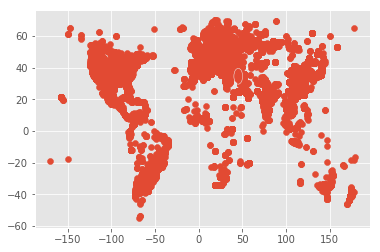

In [18]:
plt.style.use('ggplot')
circle = plt.Circle((45.3453, 34.4997), fill=False)
ax = plt.gca()
ax.scatter(longs, lats)
ax.add_artist(circle)
plt.show()

**Analysis of IP Addresses for Sanctioned Regions**

In [20]:
country_df = df.groupby('Country Names')['IP Addresses'].count()

In [29]:
sanctions_df = country_df.loc[['Iran', 'Iraq', 'North Korea', 'Syria', 'Cuba', 'Sudan']]

/Users/garrettransom/data_analytics/data_env/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [22]:
sanctions_df

Country Names
Iran           128.0
Iraq             4.0
North Korea      NaN
Syria           12.0
Cuba             4.0
Sudan           14.0
Name: IP Addresses, dtype: float64

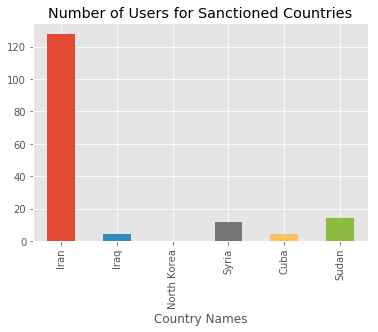

In [23]:
sanctions_df.plot.bar(title='Number of Users for Sanctioned Countries')

**Countries with the Most Nodes**

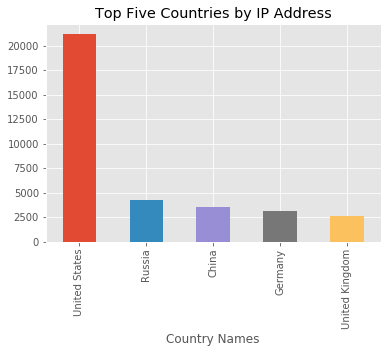

In [28]:
x = country_df.sort_values(ascending=False)
top_five = x[0:5]
top_five.plot(kind='bar', title='Top Five Countries by IP Address')

## Conclusion

After conducting our analysis, we see that we have nodes within our database to further investigate. Having 128 nodes from Iran was a surprise and because of the blemishes of geolocation libaries, we'll look to further solidify our intial findings. It is our goal to continue forming an honest, compliant, and high-performing network to our end users.